In [1]:
import pandas as pd
import numpy as np

In [2]:
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [3]:
titanic = pd.read_csv('datasets/titanic/train.csv')

In [4]:
titanic.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [5]:
titanic.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
PassengerId    891 non-null int64
Survived       891 non-null int64
Pclass         891 non-null int64
Name           891 non-null object
Sex            891 non-null object
Age            714 non-null float64
SibSp          891 non-null int64
Parch          891 non-null int64
Ticket         891 non-null object
Fare           891 non-null float64
Cabin          204 non-null object
Embarked       889 non-null object
dtypes: float64(2), int64(5), object(5)
memory usage: 83.6+ KB


In [6]:
titanic.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


### Let's try imputing vals to missing vals

In [7]:
mv_cols = (titanic.isnull().sum())
print(mv_cols[mv_cols > 0])

Age         177
Cabin       687
Embarked      2
dtype: int64


In [8]:
# Impute Embarked
titanic['Embarked'] = titanic['Embarked'].fillna('S')

In [9]:
# Impute Cabin with NA, later we will create a new feat based on this
titanic['Cabin'] = titanic['Cabin'].fillna('NA')

### Let's prepare train set for training except for Age (ie. feat engineering, etc in all but Age)

In [10]:
titanic['Has_cabin'] = titanic['Cabin'].apply(lambda x: 0 if x == 'NA' else 1)
titanic['FamilySize'] = titanic['SibSp'] + titanic['Parch'] + 1
titanic['Is_alone'] = titanic['FamilySize'].apply(lambda x: 1 if x == 1 else 0)

#### Scale Fare

In [11]:
from sklearn.preprocessing import PowerTransformer

In [12]:
fareScaler = PowerTransformer()
titanic['Fare_scaled'] = fareScaler.fit_transform(titanic['Fare'].values.reshape(-1, 1))

In [13]:
unnecessary_cols = ['PassengerId','Name','SibSp','Parch','Ticket','Fare','Cabin']

In [14]:
titanic.drop(unnecessary_cols, inplace=True, axis=1)

In [15]:
titanic = pd.get_dummies(titanic)

In [16]:
titanic.head()

,Survived,Pclass,Age,Has_cabin,FamilySize,Is_alone,Fare_scaled,Sex_female,Sex_male,Embarked_C,Embarked_Q,Embarked_S
0,0,3,22.0,0,2,0,-0.878820,0,1,0,0,1
1,1,1,38.0,1,2,0,1.336651,1,0,1,0,0
2,1,3,26.0,0,1,1,-0.790065,1,0,0,0,1
3,1,1,35.0,1,2,0,1.067352,1,0,0,0,1
4,0,3,35.0,0,1,1,-0.774439,0,1,0,0,1


### Train a regressor on Age

In [17]:
mv_cols = (titanic.isnull().sum())
print(mv_cols[mv_cols > 0])

Age    177
dtype: int64


In [18]:
#### X and y must contain rows where Age isnt null!
X = titanic.dropna().drop(['Age','Survived'], inplace=False, axis=1)
y = titanic['Age'].dropna()

In [19]:
from sklearn.model_selection import KFold
from sklearn.metrics import mean_absolute_error, r2_score

In [20]:
from sklearn.ensemble import RandomForestRegressor

#### RandomForest Regressor

In [21]:
kFold = KFold(n_splits=10, random_state=0, shuffle=True)

In [22]:
maes = []
r2s = []
for i, (train_idx, test_idx) in enumerate(kFold.split(X, y)):
    print('Fold:', i)
    X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
    y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]
    
    modelRF_age = RandomForestRegressor(random_state=0)
    modelRF_age.fit(X_train, y_train)
    preds = modelRF_age.predict(X_test)
    
    mae = mean_absolute_error(y_test, preds)
    r2 = r2_score(y_test, preds)
    print('MAE:', mae, 'R2:', r2)
    maes.append(mae)
    r2s.append(r2)
    print()
print('Avg MAE:', np.mean(maes))
print('Avg R2:', np.mean(r2s))

Fold: 0
MAE: 10.043227345124851 R2: 0.250087344630606

Fold: 1
MAE: 12.233418464509608 R2: -0.14603794166030815

Fold: 2
MAE: 12.134718727198665 R2: -0.19048586960581604

Fold: 3
MAE: 10.228954003605317 R2: -0.022954784478501633

Fold: 4
MAE: 11.771185705307268 R2: 0.03642519362990004

Fold: 5
MAE: 10.15106892738615 R2: 0.09901579165600782

Fold: 6
MAE: 10.25451951080698 R2: 0.007113559018870674

Fold: 7
MAE: 12.577477002570292 R2: -0.00895578198672009

Fold: 8
MAE: 9.954230822828006 R2: 0.2472934646809436

Fold: 9
MAE: 11.930551204670477 R2: 0.027687403593944504

Avg MAE: 11.127935171400761
Avg R2: 0.029918837947892674


##### --- r2 is very low capturing the fact that the features are not responsible for the target variable (Age) ---

##### Let's do some grid search

In [23]:
from sklearn.model_selection import GridSearchCV

In [24]:
params = {
    'n_estimators': list(range(150,250,10)),
    'max_depth': list(range(5, 20, 5)),
    'max_features': [2, 3, 4, 5],
    'max_leaf_nodes': list(range(5, 20, 5))
}

In [ ]:
gridRF = GridSearchCV(modelRF_age, param_grid=params, cv=10)
gridRF.fit(X, y)
print(gridRF.best_params_)

In [25]:
maes = []
r2s = []
for i, (train_idx, test_idx) in enumerate(kFold.split(X, y)):
    print('Fold:', i)
    X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
    y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]
    
    modelRF_age = RandomForestRegressor(random_state=0,
                                    max_depth=5,
                                    n_estimators=220,
                                    max_features=4,
                                    max_leaf_nodes=15
                                   )
    modelRF_age.fit(X_train, y_train)
    preds = modelRF_age.predict(X_test)
    
    mae = mean_absolute_error(y_test, preds)
    r2 = r2_score(y_test, preds)
    print('MAE:', mae, 'R2:', r2)
    maes.append(mae)
    r2s.append(r2)
    print()
print('Avg MAE:', np.mean(maes))
print('Avg R2:', np.mean(r2s))

Fold: 0
MAE: 10.383973947145542 R2: 0.2448205741143522

Fold: 1
MAE: 10.271463999091903 R2: 0.15069801585894937

Fold: 2
MAE: 9.882759006752037 R2: 0.21796359714429114

Fold: 3
MAE: 9.403491161022364 R2: 0.1977967519784538

Fold: 4
MAE: 10.769280803148543 R2: 0.16592845497303532

Fold: 5
MAE: 9.54806818935891 R2: 0.2392381705981086

Fold: 6
MAE: 9.628212820619076 R2: 0.21374883099984743

Fold: 7
MAE: 11.596591999047153 R2: 0.15538225521212767

Fold: 8
MAE: 9.075700408377058 R2: 0.37218296750585256

Fold: 9
MAE: 10.840918889945304 R2: 0.17808406141698974

Avg MAE: 10.140046122450789
Avg R2: 0.2135843679802008


#### XGBoost Regressor

In [26]:
from xgboost import XGBRegressor

/home/hernandezurbina/Dev/dltf/tf/lib/python3.5/site-packages/xgboost/__init__.py:29: FutureWarning: Python 3.5 support is deprecated; XGBoost will require Python 3.6+ in the near future. Consider upgrading to Python 3.6+.
  FutureWarning)


In [27]:
maes = []
r2s = []
for i, (train_idx, test_idx) in enumerate(kFold.split(X, y)):
    print('Fold:', i)
    X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
    y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]
    
    modelXGB_age = XGBRegressor(random_state=0)
    modelXGB_age.fit(X_train, y_train)
    preds = modelXGB_age.predict(X_test)
    
    mae = mean_absolute_error(y_test, preds)
    r2 = r2_score(y_test, preds)
    print('MAE:', mae, 'R2:', r2)
    maes.append(mae)
    r2s.append(r2)
    print()
print('Avg MAE:', np.mean(maes))
print('Avg R2:', np.mean(r2s))

Fold: 0
MAE: 11.591404664251538 R2: 0.06984378736366126

Fold: 1
MAE: 12.010185613632201 R2: -0.22776893082839655

Fold: 2
MAE: 11.902800056669447 R2: -0.15911992431567512

Fold: 3
MAE: 11.311499496301016 R2: -0.24455072448962056

Fold: 4
MAE: 11.278886575698852 R2: 0.023823445028524737

Fold: 5
MAE: 10.600565056330723 R2: -0.02745982259959967

Fold: 6
MAE: 10.666241055878114 R2: -0.003988613264217289

Fold: 7
MAE: 13.160571890817561 R2: -0.041588841503691576

Fold: 8
MAE: 10.544452902296898 R2: 0.11983608302112203

Fold: 9
MAE: 12.927143650995173 R2: -0.17801918911320058

Avg MAE: 11.599375096287153
Avg R2: -0.06689927307010933


##### Grid Search on XGBRegressor

In [28]:
params = {
        'min_child_weight': [1, 5, 10],
        'gamma': [0, 0.5, 1, 1.5, 2, 5],
        'subsample': [0.6, 0.8, 1.0],
        'colsample_bytree': [0.6, 0.8, 1.0],
        'n_estimators': [100, 200, 250],
        'max_depth': [4, 6, 10, 15]
        }

In [ ]:
gridXGB = GridSearchCV(modelXGB_age, param_grid=params, cv=10)
gridXGB.fit(X, y)
print(gridXGB.best_params_)

In [29]:
maes = []
r2s = []
for i, (train_idx, test_idx) in enumerate(kFold.split(X, y)):
    print('Fold:', i)
    X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
    y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]
    
    modelXGB_age = XGBRegressor(random_state=0,
                            max_depth=4,
                            gamma=5,
                            colsample_bytree=0.6,
                            n_estimators=100,
                            min_child_weight=10,
                            subsample=1.0
                           )
    modelXGB_age.fit(X_train, y_train)
    preds = modelXGB_age.predict(X_test)
    
    mae = mean_absolute_error(y_test, preds)
    r2 = r2_score(y_test, preds)
    print('MAE:', mae, 'R2:', r2)
    maes.append(mae)
    r2s.append(r2)
    print()
print('Avg MAE:', np.mean(maes))
print('Avg R2:', np.mean(r2s))

Fold: 0
MAE: 10.20902492046356 R2: 0.23510534101374791

Fold: 1
MAE: 11.05487967967987 R2: -0.03586527633880565

Fold: 2
MAE: 11.146930042240355 R2: -0.038208342870536205

Fold: 3
MAE: 10.373601290914747 R2: -0.01214913623345204

Fold: 4
MAE: 10.734323715424873 R2: 0.15324050917399046

Fold: 5
MAE: 9.971795094449757 R2: 0.14751773177362915

Fold: 6
MAE: 9.743791769323213 R2: 0.1525727487998254

Fold: 7
MAE: 12.081312260157626 R2: 0.05342366160685463

Fold: 8
MAE: 8.965310311653244 R2: 0.3794218195484308

Fold: 9
MAE: 11.855451053297015 R2: 0.06528819153996956

Avg MAE: 10.613642013760426
Avg R2: 0.11003472480136538


### Let's impute Age with our RF regressor

In [30]:
X.head()

,Pclass,Has_cabin,FamilySize,Is_alone,Fare_scaled,Sex_female,Sex_male,Embarked_C,Embarked_Q,Embarked_S
0,3,0,2,0,-0.878820,0,1,0,0,1
1,1,1,2,0,1.336651,1,0,1,0,0
2,3,0,1,1,-0.790065,1,0,0,0,1
3,1,1,2,0,1.067352,1,0,0,0,1
4,3,0,1,1,-0.774439,0,1,0,0,1


In [31]:
titanic_AgeNull = titanic[titanic['Age'].isnull()] ## 177 rows
titanic_AgeNotNull = titanic[titanic['Age'].notnull()] ## 714 rows

In [32]:
preds = modelRF_age.predict(titanic_AgeNull.drop(['Survived','Age'], axis=1, inplace=False))

In [33]:
preds.shape

(177,)

In [34]:
titanic_AgeNull.head()

,Survived,Pclass,Age,Has_cabin,FamilySize,Is_alone,Fare_scaled,Sex_female,Sex_male,Embarked_C,Embarked_Q,Embarked_S
5,0,3,NaN,0,1,1,-0.725002,0,1,0,1,0
17,1,2,NaN,0,1,1,-0.294907,0,1,0,0,1
19,1,3,NaN,0,1,1,-0.882259,1,0,1,0,0
26,0,3,NaN,0,1,1,-0.882259,0,1,1,0,0
28,1,3,NaN,0,1,1,-0.795850,1,0,0,1,0


In [35]:
titanic_AgeImputed = pd.DataFrame({'Survived':titanic_AgeNull['Survived'],
                                   'Pclass': titanic_AgeNull['Pclass'],
                                   'Age': titanic_AgeNull['Age'],
                                   'Has_cabin': titanic_AgeNull['Has_cabin'],
                                   'FamilySize': titanic_AgeNull['FamilySize'],
                                   'Is_alone': titanic_AgeNull['Is_alone'],
                                   'Fare_scaled': titanic_AgeNull['Fare_scaled'],
                                   'Sex_female': titanic_AgeNull['Sex_female'],
                                   'Sex_male': titanic_AgeNull['Sex_male'],
                                   'Embarked_C': titanic_AgeNull['Embarked_C'],
                                   'Embarked_Q': titanic_AgeNull['Embarked_Q'],
                                   'Embarked_S': titanic_AgeNull['Embarked_S'],
                                   'Age_imputed': preds
                                  })

In [36]:
titanic_AgeImputed.head()

,Age,Age_imputed,Embarked_C,Embarked_Q,Embarked_S,FamilySize,Fare_scaled,Has_cabin,Is_alone,Pclass,Sex_female,Sex_male,Survived
5,NaN,29.215264,0,1,0,1,-0.725002,0,1,3,0,1,0
17,NaN,33.271150,0,0,1,1,-0.294907,0,1,2,0,1,1
19,NaN,24.274748,1,0,0,1,-0.882259,0,1,3,1,0,1
26,NaN,28.446250,1,0,0,1,-0.882259,0,1,3,0,1,0
28,NaN,25.184539,0,1,0,1,-0.795850,0,1,3,1,0,1


In [37]:
titanic_AgeNotNull = pd.DataFrame({'Survived':titanic_AgeNotNull['Survived'],
                                   'Pclass': titanic_AgeNotNull['Pclass'],
                                   'Age': titanic_AgeNotNull['Age'],
                                   'Has_cabin': titanic_AgeNotNull['Has_cabin'],
                                   'FamilySize': titanic_AgeNotNull['FamilySize'],
                                   'Is_alone': titanic_AgeNotNull['Is_alone'],
                                   'Fare_scaled': titanic_AgeNotNull['Fare_scaled'],
                                   'Sex_female': titanic_AgeNotNull['Sex_female'],
                                   'Sex_male': titanic_AgeNotNull['Sex_male'],
                                   'Embarked_C': titanic_AgeNotNull['Embarked_C'],
                                   'Embarked_Q': titanic_AgeNotNull['Embarked_Q'],
                                   'Embarked_S': titanic_AgeNotNull['Embarked_S'],
                                   'Age_imputed': titanic_AgeNotNull['Age']
                                  })

In [38]:
titanic_AgeNotNull.head()

,Age,Age_imputed,Embarked_C,Embarked_Q,Embarked_S,FamilySize,Fare_scaled,Has_cabin,Is_alone,Pclass,Sex_female,Sex_male,Survived
0,22.0,22.0,0,0,1,2,-0.878820,0,0,3,0,1,0
1,38.0,38.0,1,0,0,2,1.336651,1,0,1,1,0,1
2,26.0,26.0,0,0,1,1,-0.790065,0,1,3,1,0,1
3,35.0,35.0,0,0,1,2,1.067352,1,0,1,1,0,1
4,35.0,35.0,0,0,1,1,-0.774439,0,1,3,0,1,0


In [39]:
titanic_pre = titanic_AgeNotNull.append(titanic_AgeImputed)

In [40]:
titanic_pre.drop(['Age'], axis=1, inplace=True)

In [41]:
titanic_pre['Age_imputed'] = titanic_pre['Age_imputed'].apply(np.ceil)

In [42]:
titanic_pre.head()

,Age_imputed,Embarked_C,Embarked_Q,Embarked_S,FamilySize,Fare_scaled,Has_cabin,Is_alone,Pclass,Sex_female,Sex_male,Survived
0,22.0,0,0,1,2,-0.878820,0,0,3,0,1,0
1,38.0,1,0,0,2,1.336651,1,0,1,1,0,1
2,26.0,0,0,1,1,-0.790065,0,1,3,1,0,1
3,35.0,0,0,1,2,1.067352,1,0,1,1,0,1
4,35.0,0,0,1,1,-0.774439,0,1,3,0,1,0


In [ ]:
titanic_pre.to_csv('datasets/titanic/train_ageImputedWRF.csv')

In [43]:
mv_cols = (titanic_pre.isnull().sum())
print(mv_cols[mv_cols > 0])

Series([], dtype: int64)


### More viz

In [ ]:
"""
    SURVIVED
"""
plt.figure(figsize=(10, 5))
sns.countplot(x='Survived', data=titanic)
plt.show()

In [ ]:
"""
    PCLASS
"""
plt.figure(figsize=(10, 5))
sns.countplot(x='Pclass', data=titanic)
plt.show()

In [ ]:
plt.figure(figsize=(10, 5))
sns.countplot(x='Pclass', hue='Survived', data=titanic)
plt.show()

In [ ]:
"""
    SEX
"""
plt.figure(figsize=(10, 5))
sns.countplot(x='Sex', data=titanic)
plt.show()
### more men than women!

In [ ]:
plt.figure(figsize=(10, 5))
sns.countplot(x='Sex', hue='Survived', data=titanic)
plt.show()
## more women survived tho!

In [ ]:
"""
    EMBARKED
"""
plt.figure(figsize=(10, 5))
sns.countplot(x='Embarked', data=titanic)
plt.show()
### most people boarded on southampton

In [ ]:
plt.figure(figsize=(10, 5))
sns.countplot(x='Embarked', hue='Survived', data=titanic)
plt.show()

In [ ]:
"""
    PARCH
"""
plt.figure(figsize=(10, 5))
sns.countplot(x='Parch', data=titanic)
plt.show()
### most people traveled without parents or children

In [ ]:
plt.figure(figsize=(10, 5))
sns.countplot(x='Parch', hue='Survived', data=titanic)
plt.show()

In [ ]:
"""
    SIBSP
"""
plt.figure(figsize=(10, 5))
sns.countplot(x='SibSp', data=titanic)
plt.show()
## most people traveled without siblings or spouse

In [ ]:
plt.figure(figsize=(10, 5))
sns.countplot(x='SibSp', hue='Survived', data=titanic)
plt.show()

In [ ]:
plt.figure(figsize=(10, 5))
sns.jointplot(x="Parch", y="SibSp", data=titanic);
plt.show()

In [ ]:
"""
    AGE
"""
plt.figure(figsize=(10, 10))
sns.boxplot(x='Survived', y='Age', data=titanic)
plt.show()
## almost safe to say that if you were a child you would've survived

In [ ]:
"""
    FARE
"""
plt.figure(figsize=(10, 10))
sns.boxplot(x='Survived', y='Fare', data=titanic)
plt.show()
### mean are different. Do a t-test for significance? Cant be done! Data isnt gaussian-like
### people who paid larger fares were more likely to survive

### Here we have finished visualizing and we're ready to drop cols

In [44]:
titanic.head()

,Survived,Pclass,Age,Has_cabin,FamilySize,Is_alone,Fare_scaled,Sex_female,Sex_male,Embarked_C,Embarked_Q,Embarked_S
0,0,3,22.0,0,2,0,-0.878820,0,1,0,0,1
1,1,1,38.0,1,2,0,1.336651,1,0,1,0,0
2,1,3,26.0,0,1,1,-0.790065,1,0,0,0,1
3,1,1,35.0,1,2,0,1.067352,1,0,0,0,1
4,0,3,35.0,0,1,1,-0.774439,0,1,0,0,1


In [45]:
titanic_pre.head()

,Age_imputed,Embarked_C,Embarked_Q,Embarked_S,FamilySize,Fare_scaled,Has_cabin,Is_alone,Pclass,Sex_female,Sex_male,Survived
0,22.0,0,0,1,2,-0.878820,0,0,3,0,1,0
1,38.0,1,0,0,2,1.336651,1,0,1,1,0,1
2,26.0,0,0,1,1,-0.790065,0,1,3,1,0,1
3,35.0,0,0,1,2,1.067352,1,0,1,1,0,1
4,35.0,0,0,1,1,-0.774439,0,1,3,0,1,0


### Scaling Age_imputed

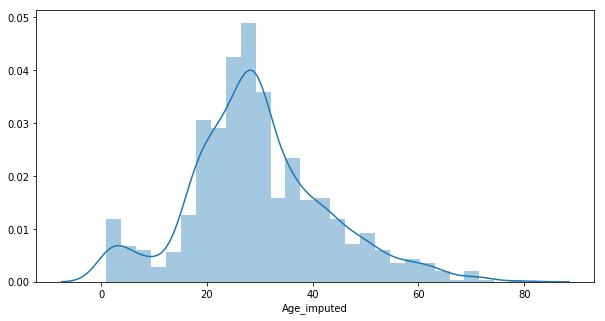

In [46]:
### how is age distributed?
plt.figure(figsize=(10, 5))
sns.distplot(titanic_pre['Age_imputed'])
plt.show()

In [47]:
from sklearn.preprocessing import MinMaxScaler

In [48]:
ageScaler = MinMaxScaler()

In [49]:
titanic_pre['Age_scaled'] = ageScaler.fit_transform(titanic_pre['Age_imputed'].values.reshape(-1, 1))

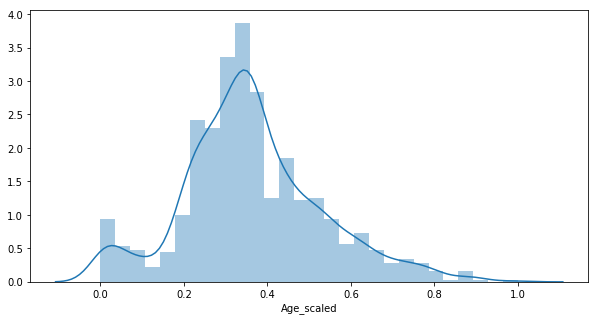

In [50]:
plt.figure(figsize=(10, 5))
sns.distplot(titanic_pre['Age_scaled'])
plt.show()

In [51]:
titanic_pre.drop(['Age_imputed'], axis=1, inplace=True)
titanic_pre.head()

,Embarked_C,Embarked_Q,Embarked_S,FamilySize,Fare_scaled,Has_cabin,Is_alone,Pclass,Sex_female,Sex_male,Survived,Age_scaled
0,0,0,1,2,-0.878820,0,0,3,0,1,0,0.265823
1,1,0,0,2,1.336651,1,0,1,1,0,1,0.468354
2,0,0,1,1,-0.790065,0,1,3,1,0,1,0.316456
3,0,0,1,2,1.067352,1,0,1,1,0,1,0.430380
4,0,0,1,1,-0.774439,0,1,3,0,1,0,0.430380


## Are we ready to model?

In [52]:
X = titanic_pre.drop('Survived', axis=1, inplace=False)
y = titanic_pre['Survived']

In [53]:
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, f1_score, roc_curve, auc
from sklearn.model_selection import StratifiedKFold

In [54]:
kFold = StratifiedKFold(n_splits=10, random_state=0, shuffle=True)

### Logistic Regression

In [55]:
from sklearn.linear_model import LogisticRegression

In [74]:
accs = []
f1s = []
for i, (train_idx, test_idx) in enumerate(kFold.split(X, y)):
    print('Fold:', i)
    X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
    y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]
    
    modelLR = LogisticRegression(random_state=0)
    
    modelLR.fit(X_train, y_train)
    preds = modelLR.predict(X_test)
    acc = accuracy_score(y_test, preds)
    f1 = f1_score(y_test, preds)
    accs.append(acc)
    f1s.append(f1)
    print('Acc:', acc, 'F1:', f1)
    print()
print('Mean acc:', np.mean(accs))
print('Mean F1:', np.mean(f1s))

Fold: 0
Acc: 0.8111111111111111 F1: 0.7536231884057971

Fold: 1
Acc: 0.7865168539325843 F1: 0.6984126984126984

Fold: 2
Acc: 0.8202247191011236 F1: 0.7333333333333334

Fold: 3
Acc: 0.7640449438202247 F1: 0.6956521739130436

Fold: 4
Acc: 0.797752808988764 F1: 0.7096774193548386

Fold: 5
Acc: 0.7752808988764045 F1: 0.7058823529411765

Fold: 6
Acc: 0.8202247191011236 F1: 0.7647058823529412

Fold: 7
Acc: 0.7640449438202247 F1: 0.6769230769230768

Fold: 8
Acc: 0.8426966292134831 F1: 0.7999999999999999

Fold: 9
Acc: 0.8426966292134831 F1: 0.8055555555555555

Mean acc: 0.8024594257178526
Mean F1: 0.7343765681192461


### Random Forest

In [57]:
from sklearn.ensemble import RandomForestClassifier

In [63]:
accs = []
f1s = []
for i, (train_idx, test_idx) in enumerate(kFold.split(X, y)):
    print('Fold:', i)
    X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
    y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]
    
    modelRF = RandomForestClassifier(random_state=0)
    
    modelRF.fit(X_train, y_train)
    preds = modelRF.predict(X_test)
    acc = accuracy_score(y_test, preds)
    f1 = f1_score(y_test, preds)
    accs.append(acc)
    f1s.append(f1)
    print('Acc:', acc, 'F1:', f1)
    print()
print('Mean acc:', np.mean(accs))
print('Mean F1:', np.mean(f1s))

Fold: 0
Acc: 0.8333333333333334 F1: 0.782608695652174

Fold: 1
Acc: 0.8426966292134831 F1: 0.7741935483870968

Fold: 2
Acc: 0.797752808988764 F1: 0.735294117647059

Fold: 3
Acc: 0.7528089887640449 F1: 0.7027027027027027

Fold: 4
Acc: 0.8314606741573034 F1: 0.7692307692307693

Fold: 5
Acc: 0.8089887640449438 F1: 0.746268656716418

Fold: 6
Acc: 0.8314606741573034 F1: 0.7692307692307693

Fold: 7
Acc: 0.7865168539325843 F1: 0.6984126984126984

Fold: 8
Acc: 0.8539325842696629 F1: 0.8169014084507041

Fold: 9
Acc: 0.8089887640449438 F1: 0.7733333333333333

Mean acc: 0.8147940074906366
Mean F1: 0.7568176699763725


In [76]:
params = {
    'n_estimators': list(range(150,250,10)),
    'max_depth': list(range(5, 20, 5)),
    'max_leaf_nodes': list(range(5, 20, 5))
}

In [77]:
grid = GridSearchCV(modelRF, param_grid=params, scoring='accuracy', cv=10)
grid.fit(X, y)
print(grid.best_params_)

{'n_estimators': 200, 'max_depth': 5, 'max_leaf_nodes': 15}


In [78]:
accs = []
f1s = []
for i, (train_idx, test_idx) in enumerate(kFold.split(X, y)):
    print('Fold:', i)
    X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
    y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]
    
    modelRF = RandomForestClassifier(random_state=0,
                                     n_estimators=200,
                                     max_depth=5,
                                     max_leaf_nodes=15
                                    )
    
    modelRF.fit(X_train, y_train)
    preds = modelRF.predict(X_test)
    acc = accuracy_score(y_test, preds)
    f1 = f1_score(y_test, preds)
    accs.append(acc)
    f1s.append(f1)
    print('Acc:', acc, 'F1:', f1)
    print()
print('Mean acc:', np.mean(accs))
print('Mean F1:', np.mean(f1s))

Fold: 0
Acc: 0.8111111111111111 F1: 0.73015873015873

Fold: 1
Acc: 0.8202247191011236 F1: 0.7419354838709677

Fold: 2
Acc: 0.8426966292134831 F1: 0.7666666666666666

Fold: 3
Acc: 0.8202247191011236 F1: 0.7500000000000001

Fold: 4
Acc: 0.8202247191011236 F1: 0.7333333333333334

Fold: 5
Acc: 0.797752808988764 F1: 0.735294117647059

Fold: 6
Acc: 0.8539325842696629 F1: 0.7999999999999999

Fold: 7
Acc: 0.797752808988764 F1: 0.7

Fold: 8
Acc: 0.8426966292134831 F1: 0.787878787878788

Fold: 9
Acc: 0.8089887640449438 F1: 0.7384615384615385

Mean acc: 0.8215605493133582
Mean F1: 0.7483728658017084


### AdaBoost

In [59]:
from sklearn.ensemble import AdaBoostClassifier

In [60]:
accs = []
f1s = []
for i, (train_idx, test_idx) in enumerate(kFold.split(X, y)):
    print('Fold:', i)
    X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
    y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]
    
    modelADA = AdaBoostClassifier(random_state=0)
    modelADA.fit(X_train, y_train)
    preds = modelADA.predict(X_test)
    
    acc = accuracy_score(y_test, preds)
    f1 = f1_score(y_test, preds)
    accs.append(acc)
    f1s.append(f1)
    print('Acc:', acc, 'F1:', f1)
    print()
print('Mean acc:', np.mean(accs))
print('Mean F1:', np.mean(f1s))

Fold: 0
Acc: 0.8444444444444444 F1: 0.7812500000000001

Fold: 1
Acc: 0.7865168539325843 F1: 0.7076923076923077

Fold: 2
Acc: 0.7865168539325843 F1: 0.7076923076923077

Fold: 3
Acc: 0.7865168539325843 F1: 0.7164179104477613

Fold: 4
Acc: 0.797752808988764 F1: 0.71875

Fold: 5
Acc: 0.797752808988764 F1: 0.7428571428571428

Fold: 6
Acc: 0.8202247191011236 F1: 0.7647058823529412

Fold: 7
Acc: 0.7752808988764045 F1: 0.696969696969697

Fold: 8
Acc: 0.8426966292134831 F1: 0.8108108108108107

Fold: 9
Acc: 0.8202247191011236 F1: 0.7777777777777778

Mean acc: 0.805792759051186
Mean F1: 0.7424923836600746


In [79]:
modelADA.get_params()

{'algorithm': 'SAMME.R',
 'base_estimator': None,
 'learning_rate': 1.0,
 'n_estimators': 50,
 'random_state': 0}

In [85]:
params = {
    'n_estimators': [50, 100, 150, 200, 250],
    'learning_rate': np.arange(0.1,1,0.1)
}

In [86]:
grid = GridSearchCV(modelADA, param_grid=params, scoring='accuracy', cv=10)
grid.fit(X, y)
print(grid.best_params_)

{'learning_rate': 0.8, 'n_estimators': 100}


In [87]:
accs = []
f1s = []
for i, (train_idx, test_idx) in enumerate(kFold.split(X, y)):
    print('Fold:', i)
    X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
    y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]
    
    modelADA = AdaBoostClassifier(random_state=0,
                                  learning_rate=0.8,
                                  n_estimators=100
                                 )
    modelADA.fit(X_train, y_train)
    preds = modelADA.predict(X_test)
    
    acc = accuracy_score(y_test, preds)
    f1 = f1_score(y_test, preds)
    accs.append(acc)
    f1s.append(f1)
    print('Acc:', acc, 'F1:', f1)
    print()
print('Mean acc:', np.mean(accs))
print('Mean F1:', np.mean(f1s))

Fold: 0
Acc: 0.8222222222222222 F1: 0.7575757575757576

Fold: 1
Acc: 0.8202247191011236 F1: 0.7714285714285715

Fold: 2
Acc: 0.8089887640449438 F1: 0.7301587301587301

Fold: 3
Acc: 0.797752808988764 F1: 0.735294117647059

Fold: 4
Acc: 0.8089887640449438 F1: 0.7384615384615385

Fold: 5
Acc: 0.7865168539325843 F1: 0.7323943661971832

Fold: 6
Acc: 0.8314606741573034 F1: 0.782608695652174

Fold: 7
Acc: 0.797752808988764 F1: 0.7272727272727272

Fold: 8
Acc: 0.8426966292134831 F1: 0.7999999999999999

Fold: 9
Acc: 0.8314606741573034 F1: 0.7945205479452055

Mean acc: 0.8148064918851435
Mean F1: 0.7569715052338946


### GradientBoost

In [61]:
from sklearn.ensemble import GradientBoostingClassifier

In [62]:
accs = []
f1s = []
for i, (train_idx, test_idx) in enumerate(kFold.split(X, y)):
    print('Fold:', i)
    X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
    y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]
    
    modelGB = GradientBoostingClassifier(random_state=0)
    modelGB.fit(X_train, y_train)
    preds = modelGB.predict(X_test)
    
    acc = accuracy_score(y_test, preds)
    f1 = f1_score(y_test, preds)
    accs.append(acc)
    f1s.append(f1)
    print('Acc:', acc, 'F1:', f1)
    print()
print('Mean acc:', np.mean(accs))
print('Mean F1:', np.mean(f1s))

Fold: 0
Acc: 0.8666666666666667 F1: 0.8125

Fold: 1
Acc: 0.8426966292134831 F1: 0.78125

Fold: 2
Acc: 0.8314606741573034 F1: 0.7761194029850745

Fold: 3
Acc: 0.797752808988764 F1: 0.7428571428571428

Fold: 4
Acc: 0.8202247191011236 F1: 0.7142857142857143

Fold: 5
Acc: 0.797752808988764 F1: 0.735294117647059

Fold: 6
Acc: 0.8539325842696629 F1: 0.7796610169491526

Fold: 7
Acc: 0.8089887640449438 F1: 0.711864406779661

Fold: 8
Acc: 0.8539325842696629 F1: 0.7999999999999999

Fold: 9
Acc: 0.797752808988764 F1: 0.7352941176470589

Mean acc: 0.827116104868914
Mean F1: 0.7589125919150863


In [88]:
modelGB.get_params()

{'ccp_alpha': 0.0,
 'criterion': 'friedman_mse',
 'init': None,
 'learning_rate': 0.1,
 'loss': 'deviance',
 'max_depth': 3,
 'max_features': None,
 'max_leaf_nodes': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_iter_no_change': None,
 'presort': 'deprecated',
 'random_state': 0,
 'subsample': 1.0,
 'tol': 0.0001,
 'validation_fraction': 0.1,
 'verbose': 0,
 'warm_start': False}

In [93]:
params = {
    'n_estimators': [50, 100, 150, 200],
    'max_depth': list(range(1, 15, 5)),
    'max_leaf_nodes': list(range(5, 20, 5)),
    'learning_rate': np.arange(0.1,1,0.1),
    'warm_start': [True, False]
}

In [94]:
grid = GridSearchCV(modelGB, param_grid=params, scoring='accuracy', cv=10)
grid.fit(X, y)
print(grid.best_params_)

{'learning_rate': 0.1, 'n_estimators': 100, 'warm_start': True, 'max_depth': 11, 'max_leaf_nodes': 15}


In [96]:
accs = []
f1s = []
for i, (train_idx, test_idx) in enumerate(kFold.split(X, y)):
    print('Fold:', i)
    X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
    y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]
    
    modelGB = GradientBoostingClassifier(random_state=0,
                                         n_estimators=100,
                                         max_depth=11,
                                         max_leaf_nodes=15
                                        )
    modelGB.fit(X_train, y_train)
    preds = modelGB.predict(X_test)
    
    acc = accuracy_score(y_test, preds)
    f1 = f1_score(y_test, preds)
    accs.append(acc)
    f1s.append(f1)
    print('Acc:', acc, 'F1:', f1)
    print()
print('Mean acc:', np.mean(accs))
print('Mean F1:', np.mean(f1s))
# best:
# Mean acc: 0.8305368289637954
# Mean F1: 0.7680796769107352

Fold: 0
Acc: 0.8222222222222222 F1: 0.7575757575757576

Fold: 1
Acc: 0.8539325842696629 F1: 0.7936507936507937

Fold: 2
Acc: 0.8202247191011236 F1: 0.7647058823529412

Fold: 3
Acc: 0.8314606741573034 F1: 0.7887323943661971

Fold: 4
Acc: 0.8089887640449438 F1: 0.7301587301587301

Fold: 5
Acc: 0.8202247191011236 F1: 0.7575757575757576

Fold: 6
Acc: 0.8314606741573034 F1: 0.7540983606557378

Fold: 7
Acc: 0.8202247191011236 F1: 0.7333333333333334

Fold: 8
Acc: 0.898876404494382 F1: 0.8656716417910447

Fold: 9
Acc: 0.797752808988764 F1: 0.7352941176470589

Mean acc: 0.8305368289637954
Mean F1: 0.7680796769107352


### XGBoost

In [64]:
from xgboost import XGBClassifier

In [65]:
accs = []
f1s = []
for i, (train_idx, test_idx) in enumerate(kFold.split(X, y)):
    print('Fold:', i)
    X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
    y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]
    
    modelXGB = XGBClassifier(random_state=0)
    modelXGB.fit(X_train, y_train)
    preds = modelXGB.predict(X_test)
    
    acc = accuracy_score(y_test, preds)
    f1 = f1_score(y_test, preds)
    accs.append(acc)
    f1s.append(f1)
    print('Acc:', acc, 'F1:', f1)
    print()
print('Mean acc:', np.mean(accs))
print('Mean F1:', np.mean(f1s))

Fold: 0
Acc: 0.8222222222222222 F1: 0.7575757575757576

Fold: 1
Acc: 0.8651685393258427 F1: 0.8000000000000002

Fold: 2
Acc: 0.7752808988764045 F1: 0.6875

Fold: 3
Acc: 0.7865168539325843 F1: 0.7323943661971832

Fold: 4
Acc: 0.8426966292134831 F1: 0.7941176470588235

Fold: 5
Acc: 0.7865168539325843 F1: 0.7246376811594202

Fold: 6
Acc: 0.8426966292134831 F1: 0.78125

Fold: 7
Acc: 0.7640449438202247 F1: 0.6666666666666667

Fold: 8
Acc: 0.8651685393258427 F1: 0.8181818181818182

Fold: 9
Acc: 0.8089887640449438 F1: 0.7605633802816902

Mean acc: 0.8159300873907614
Mean F1: 0.752288731712136


In [97]:
modelXGB.get_params()

{'base_score': 0.5,
 'booster': 'gbtree',
 'colsample_bylevel': 1,
 'colsample_bynode': 1,
 'colsample_bytree': 1,
 'gamma': 0,
 'gpu_id': -1,
 'importance_type': 'gain',
 'interaction_constraints': '',
 'learning_rate': 0.300000012,
 'max_delta_step': 0,
 'max_depth': 6,
 'min_child_weight': 1,
 'missing': nan,
 'monotone_constraints': '()',
 'n_estimators': 100,
 'n_jobs': 0,
 'num_parallel_tree': 1,
 'objective': 'binary:logistic',
 'random_state': 0,
 'reg_alpha': 0,
 'reg_lambda': 1,
 'scale_pos_weight': 1,
 'subsample': 1,
 'tree_method': 'exact',
 'validate_parameters': 1,
 'verbosity': None}

In [98]:
params = {
    'n_estimators': [50, 100, 150, 200],
    'max_depth': list(range(1, 15, 3)),
    'learning_rate': np.arange(0.1,1,0.1),
}

In [99]:
grid = GridSearchCV(modelXGB, param_grid=params, scoring='accuracy', cv=10)
grid.fit(X, y)
print(grid.best_params_)

{'learning_rate': 0.1, 'max_depth': 4, 'n_estimators': 150}


In [100]:
accs = []
f1s = []
for i, (train_idx, test_idx) in enumerate(kFold.split(X, y)):
    print('Fold:', i)
    X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
    y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]
    
    modelXGB = XGBClassifier(random_state=0, 
                             learning_rate=0.1,
                             max_depth=4,
                             n_estimators=150
                            )
    modelXGB.fit(X_train, y_train)
    preds = modelXGB.predict(X_test)
    
    acc = accuracy_score(y_test, preds)
    f1 = f1_score(y_test, preds)
    accs.append(acc)
    f1s.append(f1)
    print('Acc:', acc, 'F1:', f1)
    print()
print('Mean acc:', np.mean(accs))
print('Mean F1:', np.mean(f1s))

Fold: 0
Acc: 0.8555555555555555 F1: 0.7936507936507937

Fold: 1
Acc: 0.8539325842696629 F1: 0.7868852459016393

Fold: 2
Acc: 0.8202247191011236 F1: 0.7575757575757576

Fold: 3
Acc: 0.7865168539325843 F1: 0.7246376811594202

Fold: 4
Acc: 0.8314606741573034 F1: 0.7368421052631579

Fold: 5
Acc: 0.7865168539325843 F1: 0.7246376811594202

Fold: 6
Acc: 0.8314606741573034 F1: 0.7619047619047619

Fold: 7
Acc: 0.797752808988764 F1: 0.7

Fold: 8
Acc: 0.8764044943820225 F1: 0.8307692307692308

Fold: 9
Acc: 0.797752808988764 F1: 0.7352941176470589

Mean acc: 0.8237578027465668
Mean F1: 0.755219737503124


## Model Evaluation

In [105]:
probs = modelLR.predict_proba(X)
probs = probs[:,1]
fprLR, tprLR, _ = roc_curve(y, probs, pos_label=1)
probs = modelRF.predict_proba(X)
probs = probs[:,1]
fprRF, tprRF, _ = roc_curve(y, probs, pos_label=1)
probs = modelADA.predict_proba(X)
probs = probs[:,1]
fprADA, tprADA, _ = roc_curve(y, probs, pos_label=1)
probs = modelGB.predict_proba(X)
probs = probs[:,1]
fprGB, tprGB, _ = roc_curve(y, probs, pos_label=1)
probs = modelXGB.predict_proba(X)
probs = probs[:,1]
fprXGB, tprXGB, _ = roc_curve(y, probs, pos_label=1)

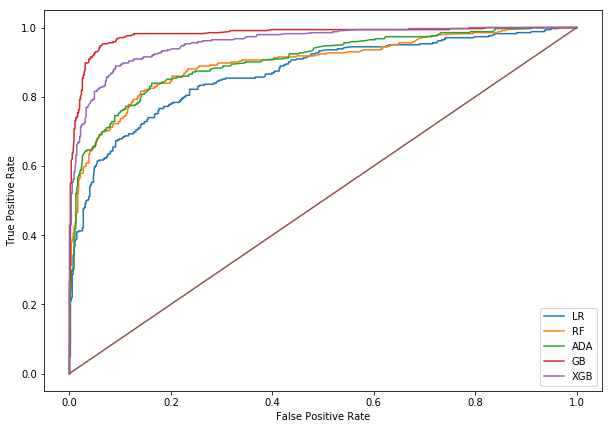

In [106]:
plt.figure(figsize=(10, 7))
plt.plot(fprLR, tprLR)
plt.plot(fprRF, tprRF)
plt.plot(fprADA, tprADA)
plt.plot(fprGB, tprGB)
plt.plot(fprXGB, tprXGB)
plt.legend(['LR','RF','ADA','GB','XGB'])
# axis labels
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.plot([0, 1], [0, 1])
# show the plot
plt.show()

# Test Set

In [107]:
test = pd.read_csv('datasets/titanic/test.csv')

In [108]:
test.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S


In [109]:
mv_cols = (test.isnull().sum())
print(mv_cols[mv_cols > 0])

Age       86
Fare       1
Cabin    327
dtype: int64


#### We're gonna need to impute Age along with other missing vals

In [112]:
test['Cabin'] = test['Cabin'].fillna('NA')
test['Fare'] = test['Fare'].fillna(test['Fare'].median())

In [113]:
test['Has_cabin'] = test['Cabin'].apply(lambda x: 0 if x == 'NA' else 1)
test['FamilySize'] = test['SibSp'] + test['Parch'] + 1
test['Is_alone'] = test['FamilySize'].apply(lambda x: 1 if x == 1 else 0)

In [120]:
test.head()

,PassengerId,Pclass,Sex,Age,Embarked,Has_cabin,FamilySize,Is_alone
0,892,3,male,34.5,Q,0,1,1
1,893,3,female,47.0,S,0,2,0
2,894,2,male,62.0,Q,0,1,1
3,895,3,male,27.0,S,0,1,1
4,896,3,female,22.0,S,0,3,0


In [115]:
test['Fare'] = fareScaler.transform(test['Fare'].values.reshape(-1, 1))

In [117]:
unnecessary_cols = ['Name','SibSp','Parch','Ticket','Fare','Cabin']

In [119]:
test.drop(unnecessary_cols, axis=1, inplace=True)